In [114]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon

In [46]:
regions = ['R11', 'R24', 'R27', 'R28', 'R32', 'R44', 'R52', 'R53', 'R75', 'R76', 'R84', 'R93', 'R94']

In [40]:
for region in regions:
    df = gpd.read_file("data/" + region + '/PARCELLES_GRAPHIQUES.shp')
    centroidxy = df.geometry.centroid 
    df["x"] = centroidxy.x
    df["y"] = centroidxy.y
    df[['ID_PARCEL', 'SURF_PARC', 'CODE_CULTU', 'CODE_GROUP', 'x', 'y']].to_csv('data/'+ region + '.csv')

R75


In [55]:
temp = []
for region in regions:
    df = pd.read_csv('data/'+ region + '.csv')[['SURF_PARC', 'CODE_CULTU', 'CODE_GROUP', 'x', 'y']]
    df['x'] = df.x.astype(int)
    df['y'] = df.y.astype(int)
    temp.append(df)

In [56]:
df = pd.concat(temp)

In [144]:
table = pd.read_csv("REF_CULTURES_GROUPES_CULTURES_2020.csv", sep=';')
table = table[['CODE_GROUPE_CULTURE', 'LIBELLE_GROUPE_CULTURE']].drop_duplicates()

In [159]:
size = 10000
df_ag = df.copy()
df_ag['x'] = (np.floor(df_ag.x / size) * size).astype(int)
df_ag['y'] = (np.floor(df_ag.y / size) * size).astype(int)
df_ag = df_ag.merge(table, left_on='CODE_GROUP', right_on='CODE_GROUPE_CULTURE')
df_ag = df_ag.groupby(['x', 'y', 'LIBELLE_GROUPE_CULTURE'], as_index=False)['SURF_PARC'].sum()
df_ag['SURF_PARC'] = df_ag['SURF_PARC'] * 10000 / (size*size) * 100  
df_ag = pd.pivot_table(df_ag, values='SURF_PARC', index=['x', 'y'], columns=['LIBELLE_GROUPE_CULTURE'], aggfunc=np.sum, fill_value=0).reset_index()

In [160]:
df_ag['geometry'] = [Polygon([(x, y), (x+size, y), (x+size, y+size), (x, y+size), (x, y)]) for x,y in zip(df_ag.x,df_ag.y)]

In [161]:
cells = gpd.GeoDataFrame(df_ag,  crs="EPSG:2154", geometry = 'geometry').drop(columns=['x', 'y'])

In [164]:
cells.columns

Index(['Autres cultures industrielles', 'Autres céréales', 'Autres oléagineux',
       'Blé tendre', 'Colza', 'Divers', 'Estives et landes', 'Fourrage',
       'Fruits à coque', 'Gel (surfaces gelées sans production)',
       'Légumes ou fleurs', 'Légumineuses à grains', 'Maïs grain et ensilage',
       'Oliviers', 'Orge', 'Plantes à fibres', 'Prairies permanentes',
       'Prairies temporaires', 'Protéagineux', 'Riz', 'Tournesol', 'Vergers',
       'Vignes', 'geometry'],
      dtype='object', name='LIBELLE_GROUPE_CULTURE')

C:\ProgramData\Anaconda3\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\ProgramData\Anaconda3\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

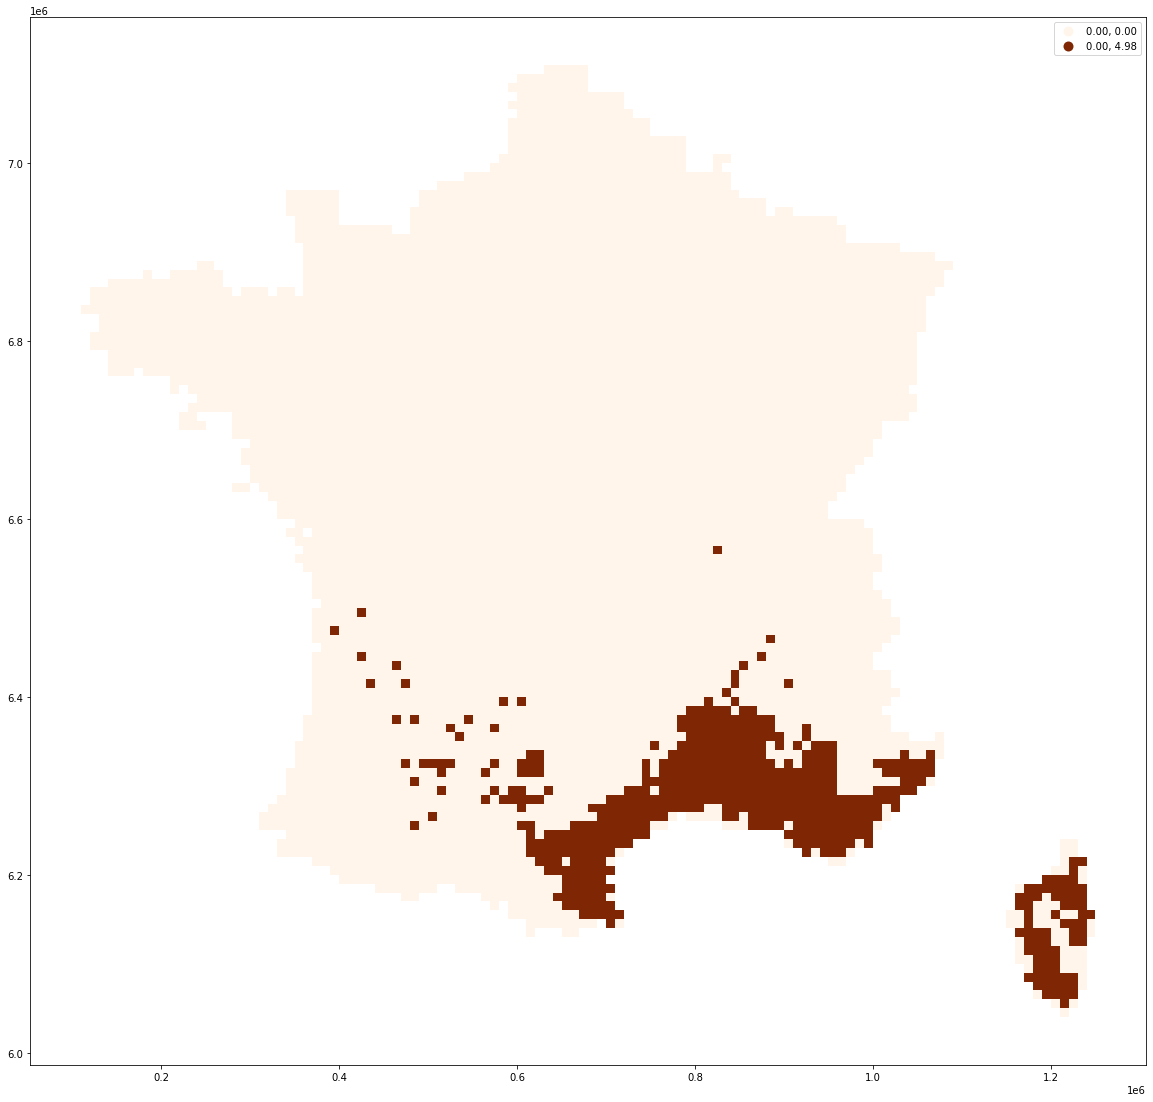

In [177]:
cells.plot('Oliviers',
               scheme="quantiles",  # use mapclassify's natural breaks scheme
               legend=True,
               cmap='Oranges',
               figsize=(20,20))

In [167]:
cells.to_file('rpg2020_10000.gpkg', driver='GPKG', layer='cells')